In [36]:
import numpy as np, sys, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit

sys.path.append(os.path.abspath(".."))
from src.evaluation import mean_impute, median_impute, SimpleLinReg, fit_fn

In [37]:
df = pd.read_csv (r"C:\Users\fangyi\bootcamp_fangyi_jiang\project\data\Processed\data_features.csv")

In [38]:
## Feature Engineering
df['return'] = (df['close'] - df['close'].shift(1))/df['close'].shift(1)
df['lag_1'] = df['return'].shift(1)
df['roll_mean_5'] = df['return'].rolling(5).mean().shift(1)
df['momentum'] = df['return'] - df['return'].shift(7)
df['y_next_ret'] = df['return'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()

In [39]:
## Split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5','momentum'] 
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
X_te

,lag_1,roll_mean_5,momentum
80,0.000561,0.002553,0.001461
81,0.000795,0.001481,-0.018511
82,-0.012988,-0.002924,-0.016664
83,-0.010508,-0.004792,-0.016116
84,-0.007080,-0.005844,-0.023838
85,-0.025004,-0.010957,0.006614
86,0.004793,-0.010157,-0.002676
87,-0.002115,-0.007983,0.050112
88,0.050907,0.004300,0.044781
89,0.031794,0.012075,0.052866


In [40]:
## I only did a classification so I am doing a regression now
X_raw = X_te['lag_1'].values
y = y_te_reg.values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
base_rmse = root_mean_squared_error(y, y_hat)
base_rmse

0.018553881942588488

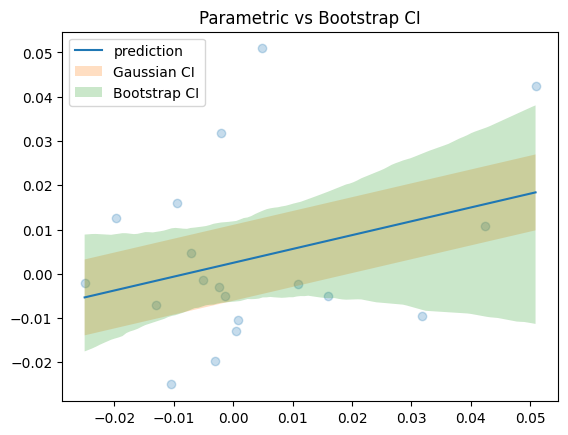

In [41]:
## Confidence Intervals
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

In [ ]:
## Senario Analysis
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
}
results = []
for name, fn in scenarios.items():
    Xs = fn(X_raw)
    m = fit_fn(Xs.reshape(-1,1), y)
    yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'rmse': root_mean_squared_error(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,rmse,slope,intercept
0,mean_impute,0.018554,0.312585,0.002485
1,median_impute,0.018554,0.312585,0.002485


In [48]:
## Alternative Senario for project stage 12
scenarios = {
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    mask = ~np.isnan(X_raw)
    Xs, ys = X_raw[mask], y[mask]
    m = fit_fn(Xs.reshape(-1,1), ys)
    yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'rmse': root_mean_squared_error(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); 
sens

,scenario,rmse,slope,intercept
0,drop_missing,0.018554,0.312585,0.002485


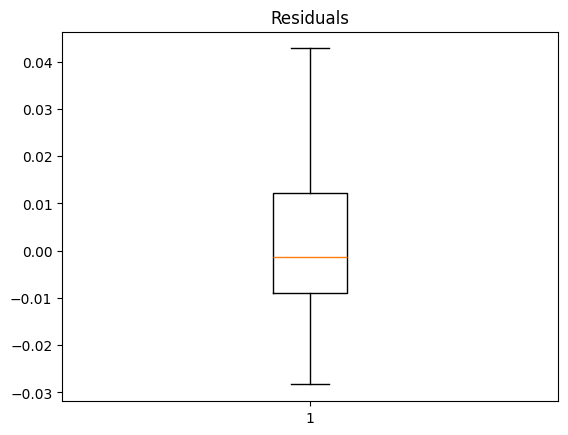

In [43]:
## Residual Patterns
residuals = y_te_reg - pred
plt.boxplot(residuals)
plt.title('Residuals')
plt.show()

In [44]:
## The key assumption is that we can predict stock price because the daily close price of a stock is normally distibuted and iid (which is totally wrong)
## Risks include hetroskadicity, size of the data (I think I only pulled about 100 days from the web and then they are split into training and testing data). Also, linear regression may not be able to fit stock price behavior well (it definately will not fit well)
## From the confidence intervals we can see that in some cases they overlap where in other cases they differ a lot. This is probably due to the small sample size leading to each bootstrap varying greatly in terms of CI.
## From the senario analysis we can see that, well I already dealt with missing data so it actually did nothing. we can't observe anything from missing data.